In [1]:
import re

from google.cloud import storage
from io import BytesIO

import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection

import category_encoders as ce

from xgboost import XGBRegressor

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from IPython.display import clear_output, display

In [2]:
mpl.style.use('bmh')

## Define Utility Functions

In [3]:
def retrieve_file(file_name, gs_bucket):
    blob = storage.Blob(file_name, gs_bucket)
    content = blob.download_as_string()
    return content

def display_description(field_name, description):
    print(re.search(re.escape(field_name) + r':.+\n\n(.+\n)+', description)[0])

def split_data_sequentially(data, test_size=0.1):
    test_length = int(len(data) * test_size)
    train = data[:-test_length].copy()
    test = data[-test_length:].copy()
    return train, test

def transform_dataset(df, **kwargs):
    if kwargs:
        features_missing_values = kwargs['features_missing_values']
        df.drop(features_missing_values, axis=1, inplace=True)
    
    for f in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        df[f].fillna('None', inplace=True)

    df.GarageYrBlt.fillna(0, inplace=True, downcast='infer')
    
    for f in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        df[f].fillna('None', inplace=True)

    df['years_built_sold'] = [max(0, sold-built) for sold, built in zip(df['YrSold'], df['YearBuilt'])]
    df['years_remod_sold'] = [max(0, sold-remod) for sold, remod in zip(df['YrSold'], df['YearRemodAdd'])]

    df['YearBuilt_cat'] = pd.cut(df['YearBuilt'],
                                 bins=[0, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010],
                                 labels=['0', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000']).astype(np.dtype('O'))

    df['YearRemodAdd_cat'] = pd.cut(df['YearRemodAdd'],
                                    bins=[0, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010],
                                    labels=['0', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000']).astype(np.dtype('O'))

    df['years_remod_sold_bins'] = pd.cut(df['years_remod_sold'],
                                         bins=[0, 5, 10, 20, 30, 40, 50, 60],
                                         labels=['0', '5', '10', '20', '30', '40', '50']).astype(np.dtype('O'))

    df['years_built_sold_bins'] = pd.cut(df['years_built_sold'],
                                         bins=[0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
                                         labels=['0', '5', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100']).astype(np.dtype('O'))

    df['year_built_x_year_remod'] = df['YearBuilt_cat'] + '_x_' + df['YearRemodAdd_cat']

    cat_features = df.dtypes[df.dtypes==np.dtype('O')].index.to_list()
    if kwargs:
        target_enc = kwargs['target_encoder']
        encoded_features = target_enc.transform(df[cat_features])
        df.loc[:, cat_features] = encoded_features
        median_values = kwargs['median_values']
        for f in df.columns:
            median_values[f] = df[f].median()
        df.fillna(median_values, inplace=True, downcast='infer')
    
    for f in ['LotArea', 'LotFrontage', '1stFlrSF', 'GrLivArea']:
        df[f + '_log'] = np.log1p(df[f])
        df.drop(f, axis=1, inplace=True)
    return df

## Ingest Data

In [4]:
client = storage.Client()

In [5]:
bucket = client.get_bucket('ames-house-dataset')

In [6]:
data = pd.read_csv(BytesIO(retrieve_file('train.csv', bucket)), index_col=0)

In [7]:
desc = retrieve_file('data_description.txt', bucket).decode('utf-8')

In [8]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Split Data

In [9]:
test_size = 0.2
random_seed = 42
train, valid = model_selection.train_test_split(data, test_size=test_size, random_state=random_seed)
train = train.copy()
valid = valid.copy()

## Identify Features With Missing Values

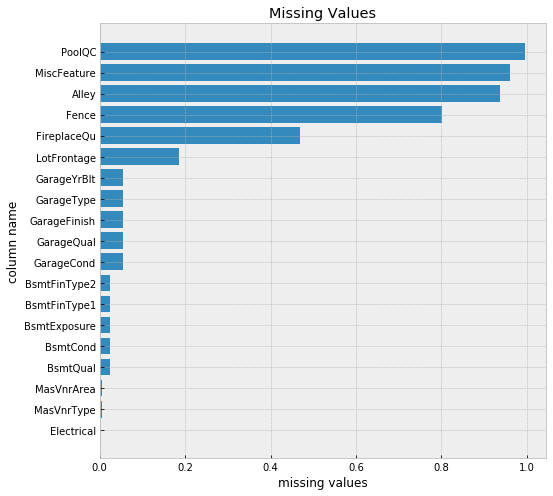

In [10]:
fig = plt.figure(figsize=(8, 8))
missing_values = train.isna().sum() / len(train)
to_plot = missing_values[missing_values > 0].sort_values()
plt.barh(to_plot.index, to_plot.values)
plt.xlabel('missing values')
plt.ylabel('column name')
plt.title('Missing Values')
plt.show()

In [11]:
display_description('LotFrontage', desc)

LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet



We can drop all features where more than 40% of the information is missing.

In [12]:
features_missing_values = missing_values[missing_values>0.4].index.to_list()

In [13]:
features_missing_values

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [14]:
train.drop(features_missing_values, axis=1, inplace=True)
missing_values = train.isna().sum() / len(train)

An interesting fact to notice is that all garage-related fields have the same number of missing values. This could indicate that houses where those features have missing values do not have garage.

In [15]:
missing_values[missing_values.index.str.match(r'^Garage') % missing_values>0]

GarageType      0.054795
GarageYrBlt     0.054795
GarageFinish    0.054795
GarageQual      0.054795
GarageCond      0.054795
dtype: float64

In [16]:
for f in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train[f].fillna('None', inplace=True)

train.GarageYrBlt.fillna(0, inplace=True, downcast='infer')
missing_values = train.isna().sum() / len(train)

We can observe the same for basement.

In [17]:
missing_values[missing_values.index.str.match(r'^Bsmt') % missing_values>0]

BsmtQual        0.023973
BsmtCond        0.023973
BsmtExposure    0.023973
BsmtFinType1    0.023973
BsmtFinType2    0.023973
dtype: float64

In [18]:
for f in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    train[f].fillna('None', inplace=True)

missing_values = train.isna().sum() / len(train)

In the case of the `MasVnrType`, `MasVnrArea` and `Electrical`, there is alreade a `None` value, so missing might mean something else. The sum of all rows where those features have missing values is less than 10, so we can just drop them. However, if we deploy the model in production, missing value encountered during serving won't be handled. Therefore, we can set a strategy where:
* For numeric features, the median will be imputed;
* For categorical features, category boosing encoding will be applied. Subsequently, the median value of the transformed feature will be imputed;

## Add New Features

In [19]:
train['years_built_sold'] = [max(0, sold-built) for sold, built in zip(train['YrSold'], train['YearBuilt'])]
train['years_remod_sold'] = [max(0, sold-remod) for sold, remod in zip(train['YrSold'], train['YearRemodAdd'])]

## Bin Selected Numerical Features

In [20]:
train['YearBuilt_cat'] = pd.cut(train['YearBuilt'],
                                bins=[0, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010],
                                labels=['0', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000']).astype(np.dtype('O'))

train['YearRemodAdd_cat'] = pd.cut(train['YearRemodAdd'],
                                   bins=[0, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010],
                                   labels=['0', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000']).astype(np.dtype('O'))

train['years_remod_sold_bins'] = pd.cut(train['years_remod_sold'],
                                        bins=[0, 5, 10, 20, 30, 40, 50, 60],
                                        labels=['0', '5', '10', '20', '30', '40', '50']).astype(np.dtype('O'))

train['years_built_sold_bins'] = pd.cut(train['years_built_sold'],
                                        bins=[0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
                                        labels=['0', '5', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100']).astype(np.dtype('O'))

## Add Feature Interactions

In [21]:
train['year_built_x_year_remod'] = train['YearBuilt_cat'] + '_x_' + train['YearRemodAdd_cat']

## Categorical Feature Encoding

In [22]:
cat_features = train.dtypes[train.dtypes==np.dtype('O')].index.to_list()

In [23]:
target_enc = ce.CatBoostEncoder(cols=cat_features)

In [24]:
target_enc.fit(train[cat_features], train.SalePrice)

CatBoostEncoder(a=1,
                cols=['MSZoning', 'Street', 'LotShape', 'LandContour',
                      'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                      'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                      'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                      'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
                      'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                      'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
                      'Electrical', 'KitchenQual', ...],
                drop_invariant=False, handle_missing='value',
                handle_unknown='value', random_state=None, return_df=True,
                sigma=None, verbose=0)

In [25]:
encoded_features = target_enc.transform(train[cat_features])
train.loc[:, cat_features] = encoded_features

## Impute Missing Values

In [26]:
median_values = dict()
for f in train.columns:
    median_values[f] = train[f].median()

In [27]:
train.fillna(median_values, inplace=True)

## Take The LOG Of All Long Tail Distributions

In [28]:
for f in ['LotArea', 'LotFrontage', '1stFlrSF', 'GrLivArea']:
    train[f + '_log'] = np.log1p(train[f])
    train.drop(f, axis=1, inplace=True)

## Train A Benchmark Model

In [29]:
params = {'features_missing_values': features_missing_values,
          'target_encoder': target_enc,
          'median_values': median_values}
valid = transform_dataset(valid, **params)

In [30]:
X_train = train.drop('SalePrice', axis=1)
y_train = train.SalePrice.values
X_valid = valid.drop('SalePrice', axis=1)
y_valid = valid.SalePrice.values

In [31]:
model = XGBRegressor(random_state=random_seed, objective='reg:squarederror', reg_lambda=1.)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

In [32]:
r2_score = metrics.r2_score(y_valid, y_pred)
explained_variance = metrics.explained_variance_score(y_valid, y_pred)
mean_abs_error = metrics.mean_absolute_error(y_valid, y_pred)
max_error = metrics.max_error(y_valid, y_pred)

print(f'The r2 score is: {r2_score:.0%}')
print(f'The explained variance score is: {explained_variance:.0%}')
print(f'The mean absolute error is: {mean_abs_error:.0f}')
print(f'The maximal error is: {max_error:.0f}')

The r2 score is: 91%
The explained variance score is: 91%
The mean absolute error is: 16262
The maximal error is: 139551


## Display The Error

In [33]:
error = y_valid - y_pred

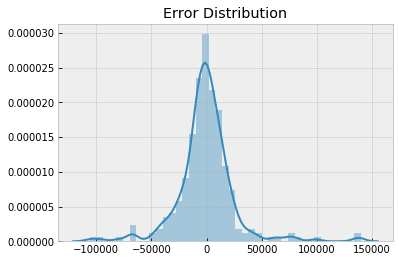

In [34]:
sns.distplot(error)
plt.title('Error Distribution')
plt.show()

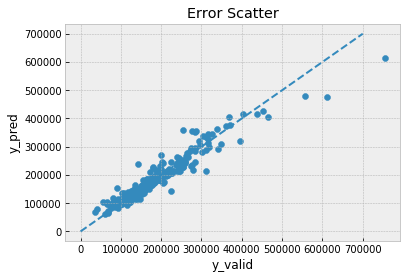

In [35]:
plt.scatter(y_valid, y_pred)
plt.title('Error Scatter')
plt.xlabel('y_valid')
plt.ylabel('y_pred')
plt.plot([0, 7e5], [0, 7e5], ls='--')
plt.show()

## Select Best Features

In [36]:
selector = feature_selection.GenericUnivariateSelect(feature_selection.chi2, 'k_best', 30)

selector.fit(X_train, train.SalePrice.values)
k_best = pd.Series(selector.scores_, index=X_train.columns)
k_best = k_best / k_best.max()

## Display Feature Importances

In [37]:
model_imp = pd.Series(model.feature_importances_, index=X_train.columns)

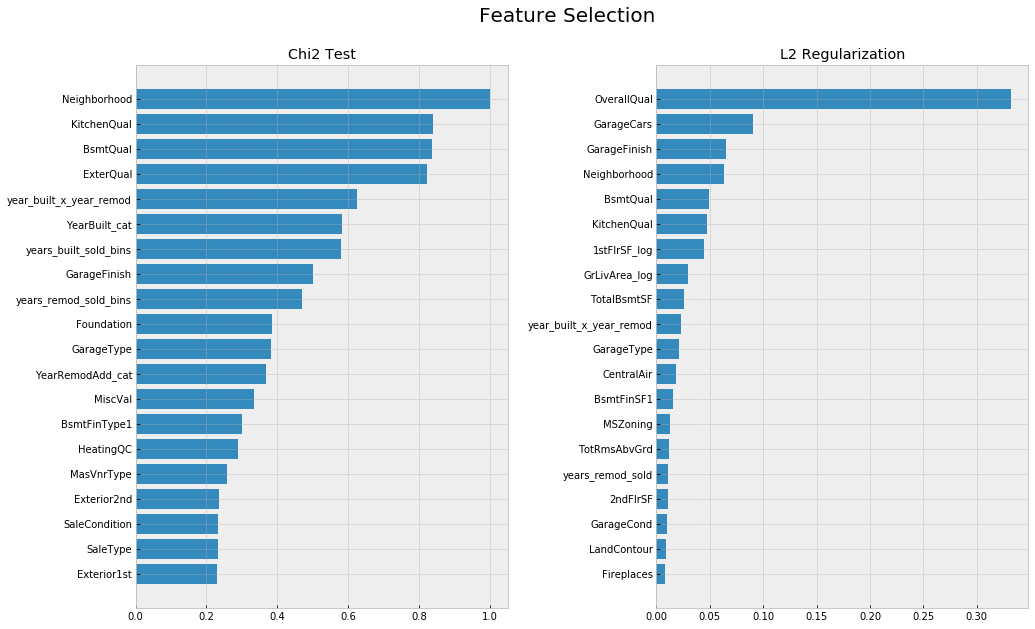

In [38]:
fig = plt.figure(figsize=(16, 10))
top_n = 20

plt.subplot(1, 2, 1)
to_plot = k_best.sort_values()[-top_n:]
plt.barh(to_plot.index, to_plot.values)
plt.title('Chi2 Test')

plt.subplot(1, 2, 2)
to_plot = model_imp.sort_values()[-top_n:]
plt.barh(to_plot.index, to_plot.values)
plt.title('L2 Regularization')

plt.subplots_adjust(wspace=0.4)
plt.suptitle('Feature Selection', y=0.96, fontsize=20)
plt.show()